In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict
from scipy.spatial.distance import cdist

dataset_path = "population_log_DE.csv"

df = pd.read_csv(dataset_path)

print("Prvních 10 záznamů:")
print(df.head(10))

print("\nPosledních 10 záznamů:")
print(df.tail(10))

print("\nInformace o datasetu:")
print(df.info())

print("\nNáhodný vzorek dat:")
print(df.sample(5))

Prvních 10 záznamů:
   generation  id      gene_0      gene_1      gene_2      gene_3      gene_4  \
0           0   0  473.532791  304.533521  -56.683713 -414.632254 -356.548817   
1           0   1   -5.267364 -489.954767  457.705017  380.228461  300.803053   
2           0   2 -103.994419 -219.109131 -353.878196  260.384512 -272.126617   
3           0   3 -417.273863 -321.329998 -206.518381  380.928124  445.833803   
4           0   4  476.733722 -328.949560 -490.494234  467.707430 -211.281250   
5           0   5 -159.182404 -486.602352  171.517241  263.808225  151.392748   
6           0   6  223.472105  436.007048  306.896378  176.207274 -251.302890   
7           0   7 -392.547985  219.313227   36.349905  392.540116 -477.301819   
8           0   8 -437.070890 -330.484636 -318.442164   11.804036 -219.000081   
9           0   9 -469.046410 -109.278121 -497.513779  421.300113  188.354127   

       gene_5      gene_6      gene_7      gene_8      gene_9  
0  470.075343   65.87032

In [4]:
def compute_inertia(data, labels, centroids):
    inertia = 0
    for i in range(len(centroids)):
        cluster_points = data[labels == i]
        inertia += np.sum((cluster_points - centroids[i])**2)
    return inertia

def elbow_plot(data, k_range):
    inertias = []
    for k in k_range:
        labels, centroids = kmeans_custom(data, k)
        inertia = compute_inertia(data, labels, centroids)
        inertias.append(inertia)

    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertias, marker='o')
    plt.title("Elbow Method for Optimal k")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (WCSS)")
    plt.grid(True)
    plt.show()

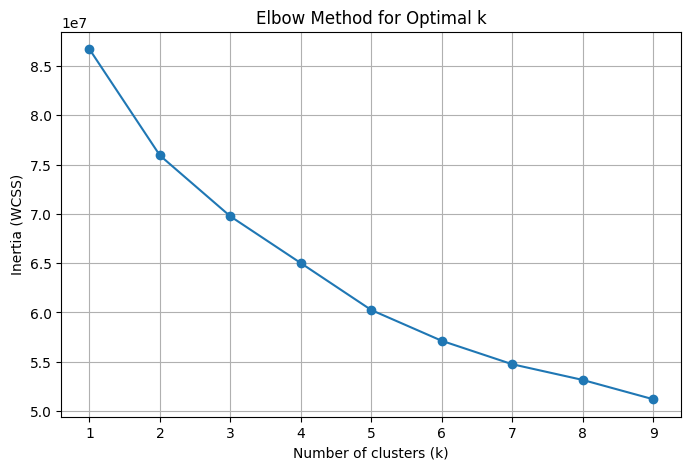

In [ ]:
df = pd.read_csv("population_log_DE.csv")
pop_data = df[df["generation"] == 0].drop(columns=["generation", "id"]).values

elbow_plot(pop_data, range(1, 10))

In [16]:
def compute_fitness(individual):
    return np.sum(np.square(individual))

def kmeans_custom(data, k, max_iters=100, tol=1e-4):
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    
    for _ in range(max_iters):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        
        centroids = new_centroids
    
    return labels, centroids

def run(dataset, num_clusters, step):
    df = pd.read_csv(dataset)

    unique_generations = sorted(df["generation"].unique())

    selected_generations = [unique_generations[0]] + unique_generations[step-1::step] + [unique_generations[-1]]

    centroid_history = []
    size_history = []
    inertia_history = []


    first_gen_data = df[df["generation"] == unique_generations[0]].drop(columns=["generation", "id"]).values
    pca = PCA(n_components=2)
    pca.fit(first_gen_data)

    id_cluster_map = defaultdict(list)


    for gen in selected_generations:
        pop_data = df[df["generation"] == gen].drop(columns=["generation", "id"]).values
        reduced_data = pca.transform(pop_data)

        clusters, centroids = kmeans_custom(pop_data, num_clusters)


        ids = df[df["generation"] == gen]["id"].values

        for ident, cl in zip(ids, clusters):
            id_cluster_map[ident].append(cl)

        # === Sledování centroidů, velikosti a kvality ===
        centroid_history.append(centroids)
        size_history.append([np.sum(clusters == i) for i in range(num_clusters)])
        inertia = compute_inertia(pop_data, clusters, centroids)
        inertia_history.append(inertia)



        #plt.figure(figsize=(6, 6))
        #scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
        #for i in range(num_clusters):
        #    plt.scatter(
        #        centroids[i, 0], centroids[i, 1], 
        #        c=[scatter.to_rgba(i)], marker='X', s=100, edgecolors='black', linewidth=1.5, label=f"Centroid {i}"
        #    )
        #plt.title(f"Generation {gen} - Custom K-Means Clustering")
        #plt.xlabel("PCA Component 1")
        #plt.ylabel("PCA Component 2")
        #plt.legend()
        #plt.show()

        centroids_2d = pca.transform(centroids)

        plt.figure(figsize=(6, 6))
        scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
        for i in range(num_clusters):
            plt.scatter(
                centroids_2d[i, 0], centroids_2d[i, 1], 
                c=[scatter.to_rgba(i)], marker='X', s=100, edgecolors='black', linewidth=1.5, label=f"Centroid {i}"
            )
        plt.title(f"Generation {gen} - Custom K-Means Clustering")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.legend()
        plt.show()


        # === Histogram velikostí clusterů ===
        cluster_sizes = [np.sum(clusters == i) for i in range(num_clusters)]
        plt.figure(figsize=(6, 4))
        plt.bar(range(num_clusters), cluster_sizes, color='skyblue', edgecolor='black')
        plt.xlabel("Index clusteru")
        plt.ylabel("Počet jedinců")
        plt.title(f"Histogram velikostí clusterů - generace {gen}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # === Analýza stability clusterů mezi generacemi ===
        if len(id_cluster_map[next(iter(id_cluster_map))]) > 1:
            stability = {i: [] for i in range(num_clusters)}  # cluster_id → seznam počtů přeběhlíků

            for gen_idx in range(1, len(selected_generations)):
                current_gen = selected_generations[gen_idx]
                previous_gen = selected_generations[gen_idx - 1]

                cluster_transitions = defaultdict(lambda: defaultdict(int))  # prev_cluster -> current_cluster -> count

                for ident, history in id_cluster_map.items():
                    if len(history) > gen_idx:
                        prev_label = history[gen_idx - 1]
                        curr_label = history[gen_idx]
                        cluster_transitions[prev_label][curr_label] += 1

                print(f"\nStabilita mezi generací {previous_gen} → {current_gen}:")
                for prev_label, curr_counts in cluster_transitions.items():
                    total = sum(curr_counts.values())
                    for curr_label, count in curr_counts.items():
                        print(f"  Cluster {prev_label} → {curr_label}: {count} jedinců ({count/total*100:.1f} %)")

        # === Boxplot fitness hodnot v jednotlivých clusterech ===
        gen_data = df[df["generation"] == gen]
        pop_values = gen_data.drop(columns=["generation", "id"]).values
        fitness_values = np.array([compute_fitness(ind) for ind in pop_values])
        cluster_fitness = [[] for _ in range(num_clusters)]

        for i, cl in enumerate(clusters):
            cluster_fitness[cl].append(fitness_values[i])

        plt.figure(figsize=(8, 5))
        plt.boxplot(cluster_fitness, labels=[f"Cluster {i}" for i in range(num_clusters)])
        plt.xlabel("Cluster")
        plt.ylabel("Fitness")
        plt.title(f"Distribuce fitness hodnot – generace {gen}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()




        switch_counts = {}
        for ident, history in id_cluster_map.items():
            switches = sum(1 for a, b in zip(history, history[1:]) if a != b)
            switch_counts[ident] = switches

        total = len(switch_counts)
        same = sum(1 for s in switch_counts.values() if s == 0)
        once = sum(1 for s in switch_counts.values() if s == 1)
        many = sum(1 for s in switch_counts.values() if s > 1)

        print("Statistiky pohybu mezi clustery:")
        print(f"Celkem jedinců: {total}")
        print(f"Zůstali ve stejném clusteru: {same} ({same/total*100:.1f} %)")
        print(f"Změnili cluster jednou: {once} ({once/total*100:.1f} %)")
        print(f"Změnili cluster vícekrát: {many} ({many/total*100:.1f} %)")

    # === Vývoj velikosti clusterů ===
    size_history = np.array(size_history)
    plt.figure(figsize=(10, 4))
    for i in range(num_clusters):
        plt.plot(selected_generations, size_history[:, i], label=f"Cluster {i}")
    plt.xlabel("Generace")
    plt.ylabel("Počet jedinců")
    plt.title("Vývoj velikosti clusterů v čase")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Vývoj inercie ===
    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, inertia_history, marker='o')
    plt.xlabel("Generace")
    plt.ylabel("WCSS (inercie)")
    plt.title("Vývoj kvality clusterů (inercie)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Vývoj průměrné vzdálenosti mezi centroidy ===
    average_intercentroid_distances = []
    for centroids in centroid_history:
        if len(centroids) < 2:
            average_intercentroid_distances.append(0)
            continue
        dists = cdist(centroids, centroids)
        upper_triangle = dists[np.triu_indices_from(dists, k=1)]
        avg_dist = np.mean(upper_triangle)
        average_intercentroid_distances.append(avg_dist)

    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, average_intercentroid_distances, marker='o', color='purple')
    plt.xlabel("Generace")
    plt.ylabel("Průměrná vzdálenost mezi centroidy")
    plt.title("Vývoj vzdáleností mezi centroidy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Výpis posunů centroidů mezi generacemi ===
    for i in range(len(centroid_history) - 1):
        print(f"\nPosun centroidů mezi generací {selected_generations[i]} a {selected_generations[i+1]}:")
        for j in range(num_clusters):
            dist = np.linalg.norm(centroid_history[i][j] - centroid_history[i+1][j])
            print(f" - Cluster {j}: {dist:.4f}")

    # === Vývoj WCSS ===
    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, inertia_history, marker='o')
    plt.xlabel("Generace")
    plt.ylabel("WCSS (inercie)")
    plt.title("Vývoj kvality clusterů (inercie) – K-Means")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



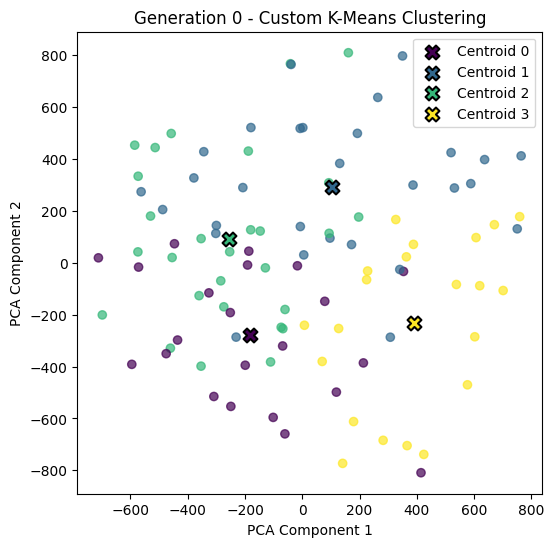

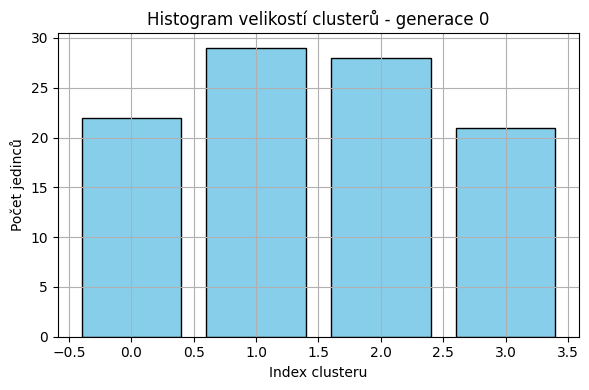

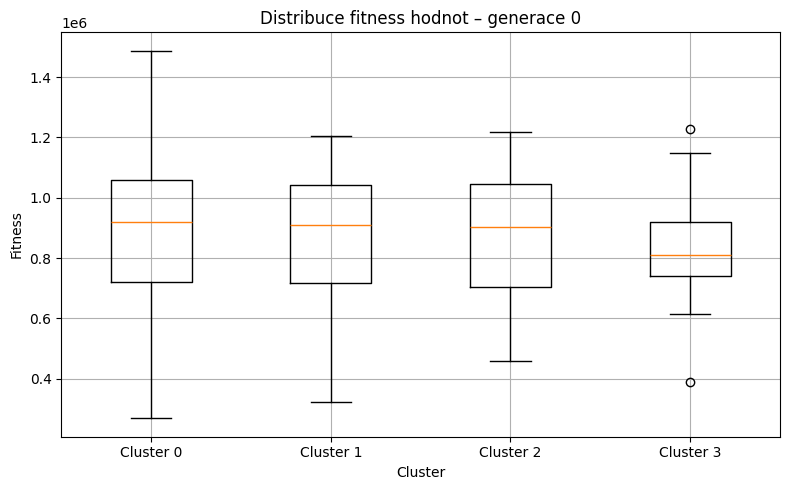

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 100 (100.0 %)
Změnili cluster jednou: 0 (0.0 %)
Změnili cluster vícekrát: 0 (0.0 %)


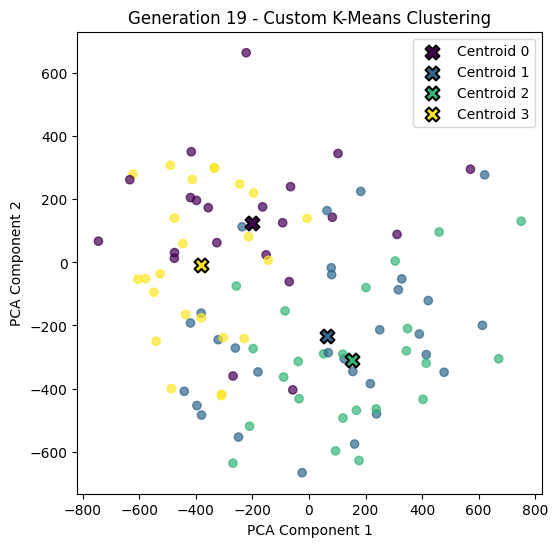

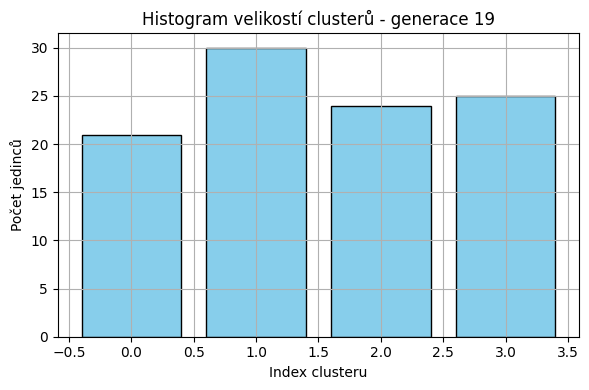


Stabilita mezi generací 0 → 19:
  Cluster 2 → 3: 7 jedinců (25.0 %)
  Cluster 2 → 2: 7 jedinců (25.0 %)
  Cluster 2 → 0: 5 jedinců (17.9 %)
  Cluster 2 → 1: 9 jedinců (32.1 %)
  Cluster 1 → 2: 9 jedinců (31.0 %)
  Cluster 1 → 0: 5 jedinců (17.2 %)
  Cluster 1 → 1: 10 jedinců (34.5 %)
  Cluster 1 → 3: 5 jedinců (17.2 %)
  Cluster 0 → 3: 7 jedinců (31.8 %)
  Cluster 0 → 1: 7 jedinců (31.8 %)
  Cluster 0 → 2: 4 jedinců (18.2 %)
  Cluster 0 → 0: 4 jedinců (18.2 %)
  Cluster 3 → 0: 7 jedinců (33.3 %)
  Cluster 3 → 2: 4 jedinců (19.0 %)
  Cluster 3 → 3: 6 jedinců (28.6 %)
  Cluster 3 → 1: 4 jedinců (19.0 %)

Stabilita mezi generací 19 → 39:

Stabilita mezi generací 39 → 59:

Stabilita mezi generací 59 → 79:

Stabilita mezi generací 79 → 99:

Stabilita mezi generací 99 → 119:

Stabilita mezi generací 119 → 139:

Stabilita mezi generací 139 → 159:

Stabilita mezi generací 159 → 179:

Stabilita mezi generací 179 → 198:


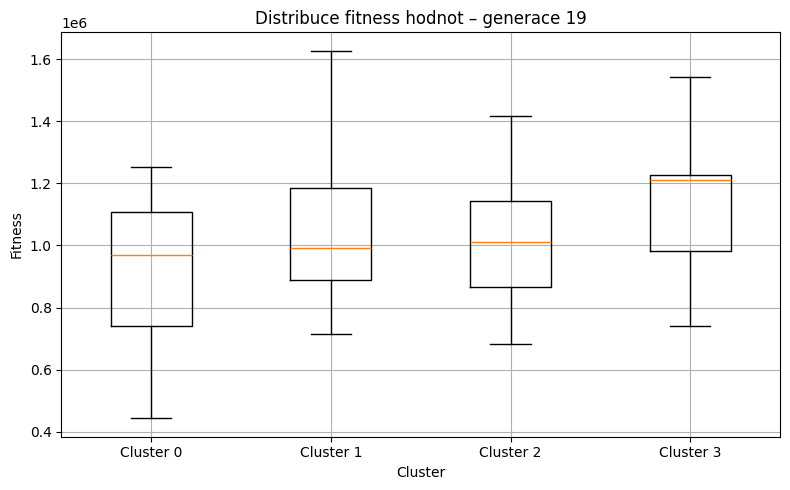

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 27 (27.0 %)
Změnili cluster jednou: 73 (73.0 %)
Změnili cluster vícekrát: 0 (0.0 %)


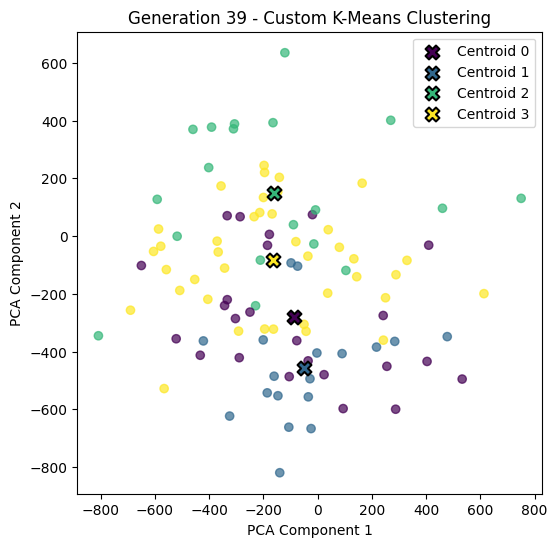

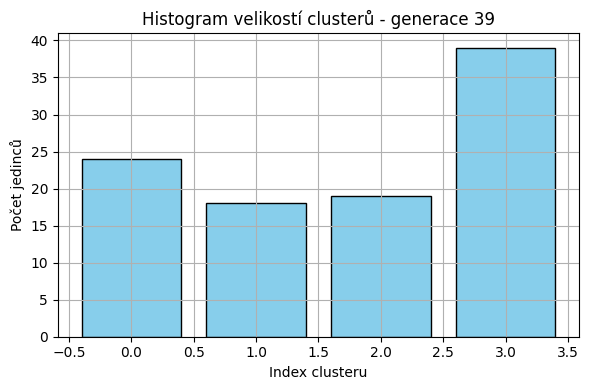


Stabilita mezi generací 0 → 19:
  Cluster 2 → 3: 7 jedinců (25.0 %)
  Cluster 2 → 2: 7 jedinců (25.0 %)
  Cluster 2 → 0: 5 jedinců (17.9 %)
  Cluster 2 → 1: 9 jedinců (32.1 %)
  Cluster 1 → 2: 9 jedinců (31.0 %)
  Cluster 1 → 0: 5 jedinců (17.2 %)
  Cluster 1 → 1: 10 jedinců (34.5 %)
  Cluster 1 → 3: 5 jedinců (17.2 %)
  Cluster 0 → 3: 7 jedinců (31.8 %)
  Cluster 0 → 1: 7 jedinců (31.8 %)
  Cluster 0 → 2: 4 jedinců (18.2 %)
  Cluster 0 → 0: 4 jedinců (18.2 %)
  Cluster 3 → 0: 7 jedinců (33.3 %)
  Cluster 3 → 2: 4 jedinců (19.0 %)
  Cluster 3 → 3: 6 jedinců (28.6 %)
  Cluster 3 → 1: 4 jedinců (19.0 %)

Stabilita mezi generací 19 → 39:
  Cluster 3 → 1: 4 jedinců (16.0 %)
  Cluster 3 → 2: 6 jedinců (24.0 %)
  Cluster 3 → 3: 12 jedinců (48.0 %)
  Cluster 3 → 0: 3 jedinců (12.0 %)
  Cluster 2 → 0: 7 jedinců (29.2 %)
  Cluster 2 → 2: 7 jedinců (29.2 %)
  Cluster 2 → 1: 4 jedinců (16.7 %)
  Cluster 2 → 3: 6 jedinců (25.0 %)
  Cluster 1 → 3: 13 jedinců (43.3 %)
  Cluster 1 → 2: 5 jedinců (16

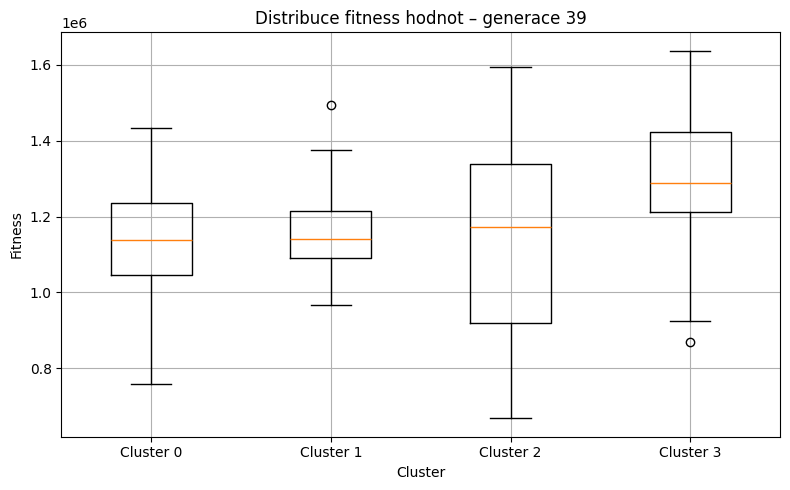

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 8 (8.0 %)
Změnili cluster jednou: 46 (46.0 %)
Změnili cluster vícekrát: 46 (46.0 %)


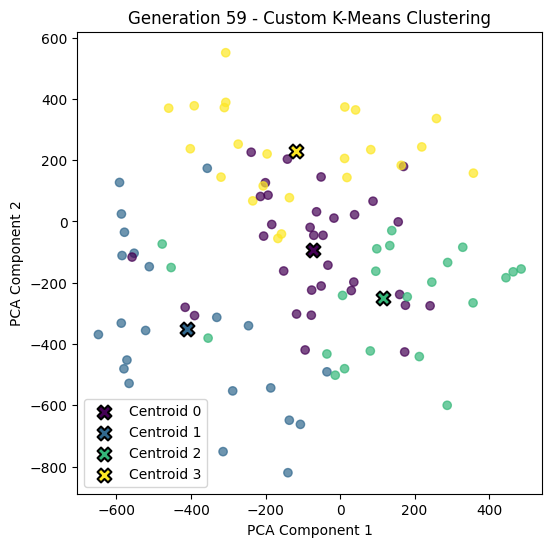

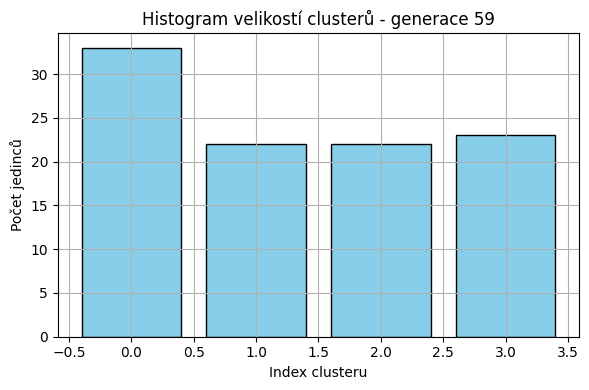


Stabilita mezi generací 0 → 19:
  Cluster 2 → 3: 7 jedinců (25.0 %)
  Cluster 2 → 2: 7 jedinců (25.0 %)
  Cluster 2 → 0: 5 jedinců (17.9 %)
  Cluster 2 → 1: 9 jedinců (32.1 %)
  Cluster 1 → 2: 9 jedinců (31.0 %)
  Cluster 1 → 0: 5 jedinců (17.2 %)
  Cluster 1 → 1: 10 jedinců (34.5 %)
  Cluster 1 → 3: 5 jedinců (17.2 %)
  Cluster 0 → 3: 7 jedinců (31.8 %)
  Cluster 0 → 1: 7 jedinců (31.8 %)
  Cluster 0 → 2: 4 jedinců (18.2 %)
  Cluster 0 → 0: 4 jedinců (18.2 %)
  Cluster 3 → 0: 7 jedinců (33.3 %)
  Cluster 3 → 2: 4 jedinců (19.0 %)
  Cluster 3 → 3: 6 jedinců (28.6 %)
  Cluster 3 → 1: 4 jedinců (19.0 %)

Stabilita mezi generací 19 → 39:
  Cluster 3 → 1: 4 jedinců (16.0 %)
  Cluster 3 → 2: 6 jedinců (24.0 %)
  Cluster 3 → 3: 12 jedinců (48.0 %)
  Cluster 3 → 0: 3 jedinců (12.0 %)
  Cluster 2 → 0: 7 jedinců (29.2 %)
  Cluster 2 → 2: 7 jedinců (29.2 %)
  Cluster 2 → 1: 4 jedinců (16.7 %)
  Cluster 2 → 3: 6 jedinců (25.0 %)
  Cluster 1 → 3: 13 jedinců (43.3 %)
  Cluster 1 → 2: 5 jedinců (16

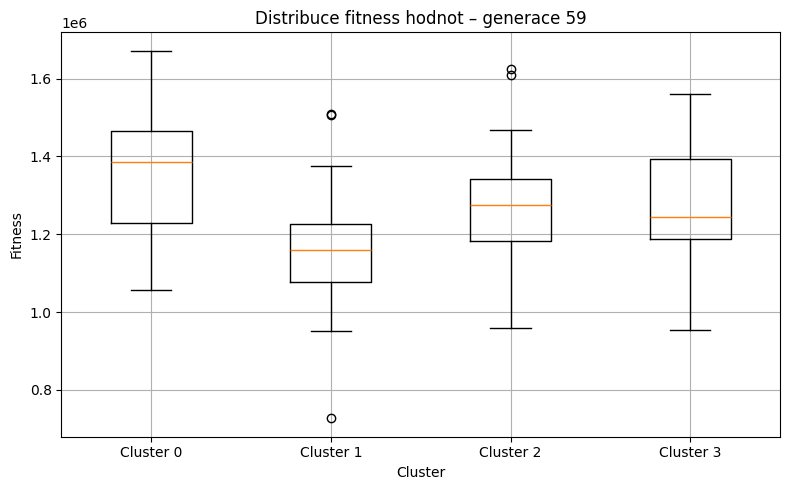

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 6 (6.0 %)
Změnili cluster jednou: 15 (15.0 %)
Změnili cluster vícekrát: 79 (79.0 %)


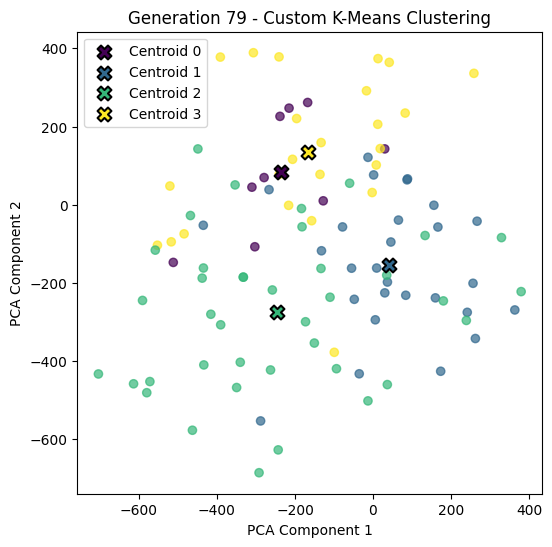

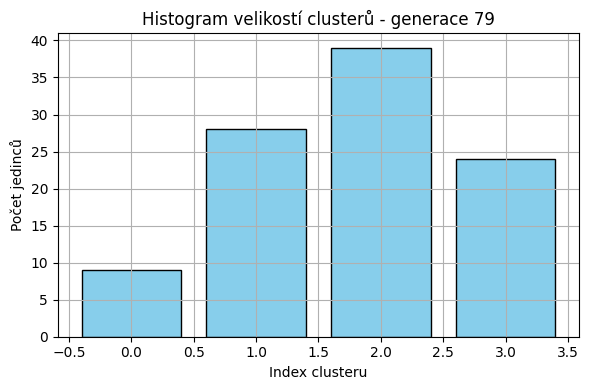


Stabilita mezi generací 0 → 19:
  Cluster 2 → 3: 7 jedinců (25.0 %)
  Cluster 2 → 2: 7 jedinců (25.0 %)
  Cluster 2 → 0: 5 jedinců (17.9 %)
  Cluster 2 → 1: 9 jedinců (32.1 %)
  Cluster 1 → 2: 9 jedinců (31.0 %)
  Cluster 1 → 0: 5 jedinců (17.2 %)
  Cluster 1 → 1: 10 jedinců (34.5 %)
  Cluster 1 → 3: 5 jedinců (17.2 %)
  Cluster 0 → 3: 7 jedinců (31.8 %)
  Cluster 0 → 1: 7 jedinců (31.8 %)
  Cluster 0 → 2: 4 jedinců (18.2 %)
  Cluster 0 → 0: 4 jedinců (18.2 %)
  Cluster 3 → 0: 7 jedinců (33.3 %)
  Cluster 3 → 2: 4 jedinců (19.0 %)
  Cluster 3 → 3: 6 jedinců (28.6 %)
  Cluster 3 → 1: 4 jedinců (19.0 %)

Stabilita mezi generací 19 → 39:
  Cluster 3 → 1: 4 jedinců (16.0 %)
  Cluster 3 → 2: 6 jedinců (24.0 %)
  Cluster 3 → 3: 12 jedinců (48.0 %)
  Cluster 3 → 0: 3 jedinců (12.0 %)
  Cluster 2 → 0: 7 jedinců (29.2 %)
  Cluster 2 → 2: 7 jedinců (29.2 %)
  Cluster 2 → 1: 4 jedinců (16.7 %)
  Cluster 2 → 3: 6 jedinců (25.0 %)
  Cluster 1 → 3: 13 jedinců (43.3 %)
  Cluster 1 → 2: 5 jedinců (16

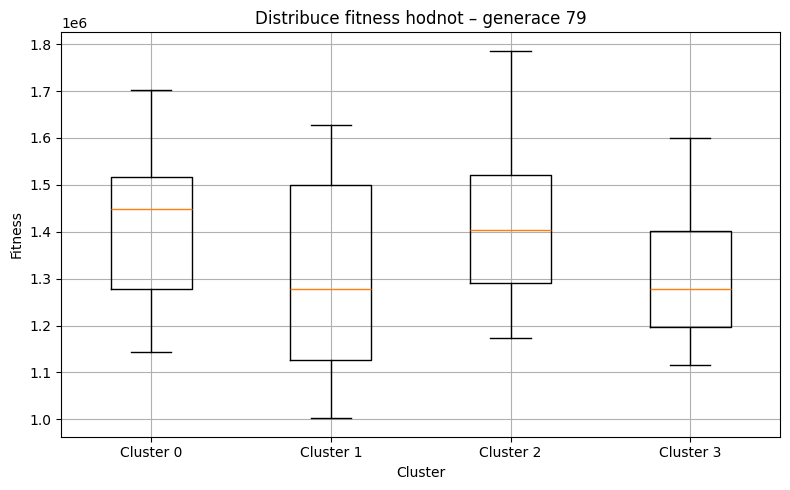

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 4 (4.0 %)
Změnili cluster jednou: 7 (7.0 %)
Změnili cluster vícekrát: 89 (89.0 %)


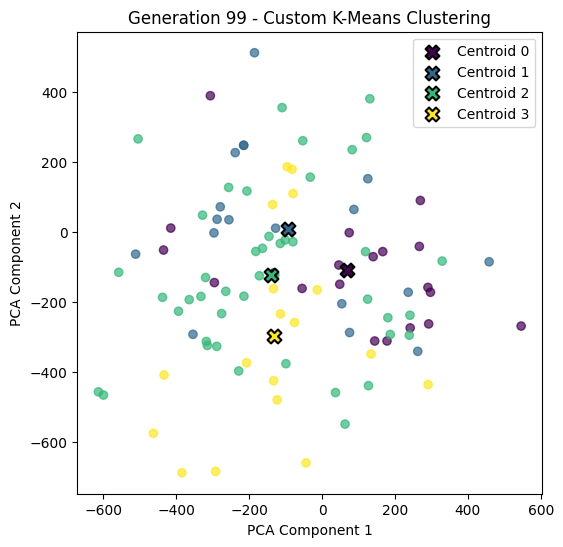

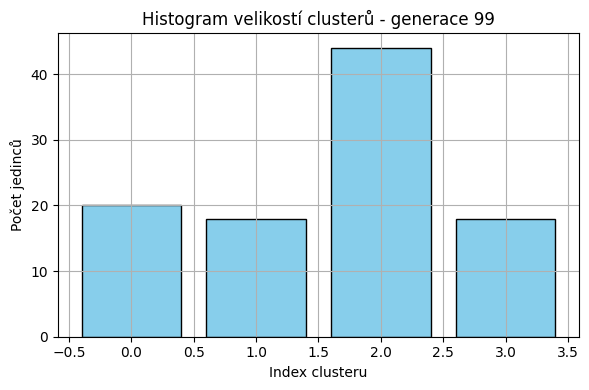


Stabilita mezi generací 0 → 19:
  Cluster 2 → 3: 7 jedinců (25.0 %)
  Cluster 2 → 2: 7 jedinců (25.0 %)
  Cluster 2 → 0: 5 jedinců (17.9 %)
  Cluster 2 → 1: 9 jedinců (32.1 %)
  Cluster 1 → 2: 9 jedinců (31.0 %)
  Cluster 1 → 0: 5 jedinců (17.2 %)
  Cluster 1 → 1: 10 jedinců (34.5 %)
  Cluster 1 → 3: 5 jedinců (17.2 %)
  Cluster 0 → 3: 7 jedinců (31.8 %)
  Cluster 0 → 1: 7 jedinců (31.8 %)
  Cluster 0 → 2: 4 jedinců (18.2 %)
  Cluster 0 → 0: 4 jedinců (18.2 %)
  Cluster 3 → 0: 7 jedinců (33.3 %)
  Cluster 3 → 2: 4 jedinců (19.0 %)
  Cluster 3 → 3: 6 jedinců (28.6 %)
  Cluster 3 → 1: 4 jedinců (19.0 %)

Stabilita mezi generací 19 → 39:
  Cluster 3 → 1: 4 jedinců (16.0 %)
  Cluster 3 → 2: 6 jedinců (24.0 %)
  Cluster 3 → 3: 12 jedinců (48.0 %)
  Cluster 3 → 0: 3 jedinců (12.0 %)
  Cluster 2 → 0: 7 jedinců (29.2 %)
  Cluster 2 → 2: 7 jedinců (29.2 %)
  Cluster 2 → 1: 4 jedinců (16.7 %)
  Cluster 2 → 3: 6 jedinců (25.0 %)
  Cluster 1 → 3: 13 jedinců (43.3 %)
  Cluster 1 → 2: 5 jedinců (16

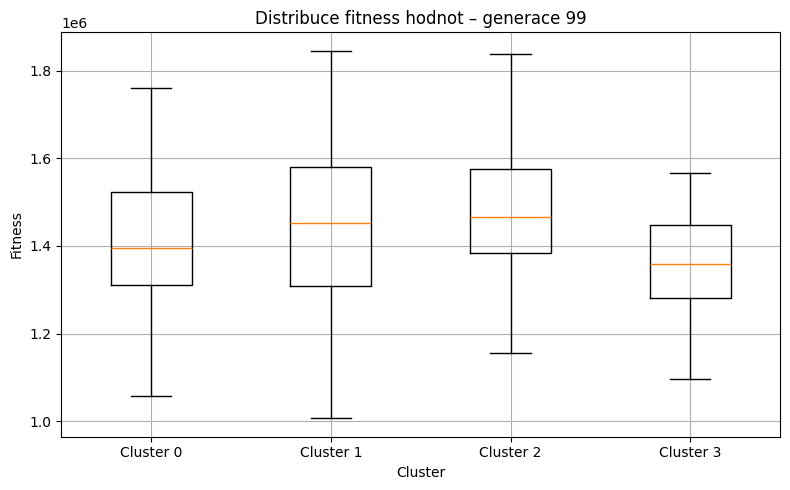

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 3 (3.0 %)
Změnili cluster jednou: 4 (4.0 %)
Změnili cluster vícekrát: 93 (93.0 %)


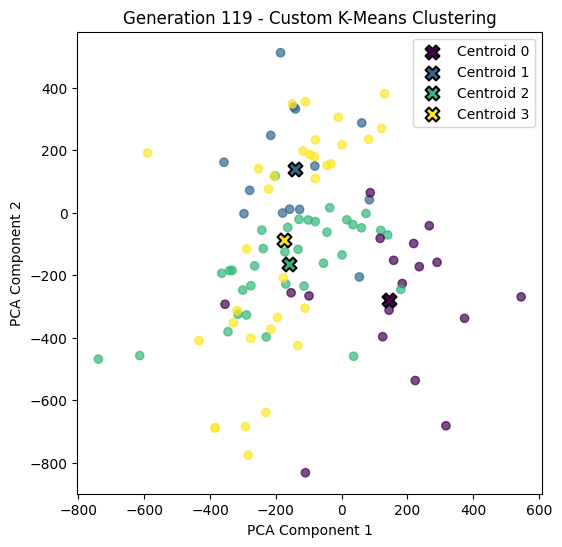

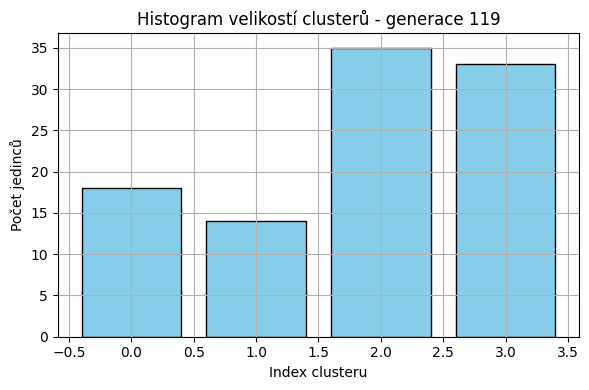


Stabilita mezi generací 0 → 19:
  Cluster 2 → 3: 7 jedinců (25.0 %)
  Cluster 2 → 2: 7 jedinců (25.0 %)
  Cluster 2 → 0: 5 jedinců (17.9 %)
  Cluster 2 → 1: 9 jedinců (32.1 %)
  Cluster 1 → 2: 9 jedinců (31.0 %)
  Cluster 1 → 0: 5 jedinců (17.2 %)
  Cluster 1 → 1: 10 jedinců (34.5 %)
  Cluster 1 → 3: 5 jedinců (17.2 %)
  Cluster 0 → 3: 7 jedinců (31.8 %)
  Cluster 0 → 1: 7 jedinců (31.8 %)
  Cluster 0 → 2: 4 jedinců (18.2 %)
  Cluster 0 → 0: 4 jedinců (18.2 %)
  Cluster 3 → 0: 7 jedinců (33.3 %)
  Cluster 3 → 2: 4 jedinců (19.0 %)
  Cluster 3 → 3: 6 jedinců (28.6 %)
  Cluster 3 → 1: 4 jedinců (19.0 %)

Stabilita mezi generací 19 → 39:
  Cluster 3 → 1: 4 jedinců (16.0 %)
  Cluster 3 → 2: 6 jedinců (24.0 %)
  Cluster 3 → 3: 12 jedinců (48.0 %)
  Cluster 3 → 0: 3 jedinců (12.0 %)
  Cluster 2 → 0: 7 jedinců (29.2 %)
  Cluster 2 → 2: 7 jedinců (29.2 %)
  Cluster 2 → 1: 4 jedinců (16.7 %)
  Cluster 2 → 3: 6 jedinců (25.0 %)
  Cluster 1 → 3: 13 jedinců (43.3 %)
  Cluster 1 → 2: 5 jedinců (16

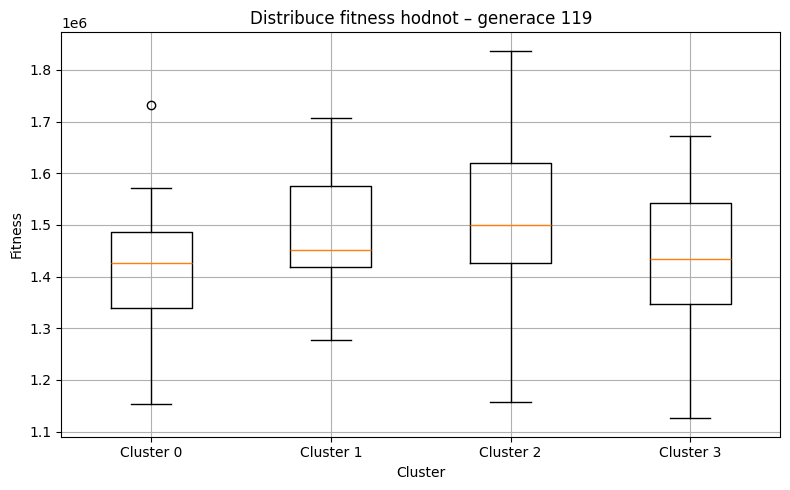

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 3 (3.0 %)
Změnili cluster jednou: 0 (0.0 %)
Změnili cluster vícekrát: 97 (97.0 %)


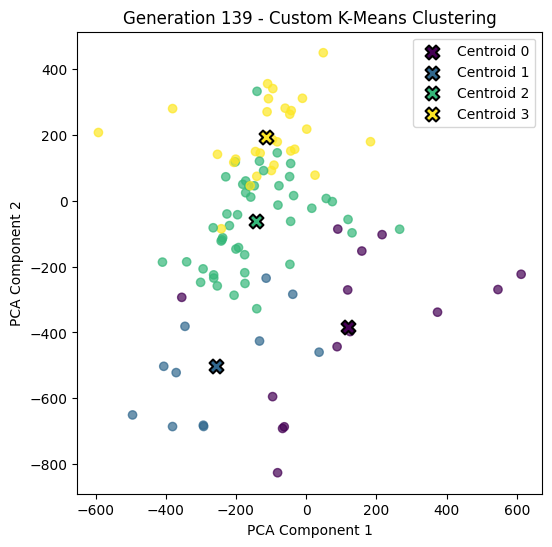

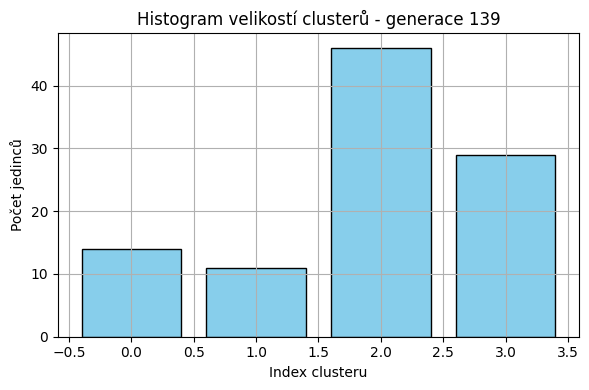


Stabilita mezi generací 0 → 19:
  Cluster 2 → 3: 7 jedinců (25.0 %)
  Cluster 2 → 2: 7 jedinců (25.0 %)
  Cluster 2 → 0: 5 jedinců (17.9 %)
  Cluster 2 → 1: 9 jedinců (32.1 %)
  Cluster 1 → 2: 9 jedinců (31.0 %)
  Cluster 1 → 0: 5 jedinců (17.2 %)
  Cluster 1 → 1: 10 jedinců (34.5 %)
  Cluster 1 → 3: 5 jedinců (17.2 %)
  Cluster 0 → 3: 7 jedinců (31.8 %)
  Cluster 0 → 1: 7 jedinců (31.8 %)
  Cluster 0 → 2: 4 jedinců (18.2 %)
  Cluster 0 → 0: 4 jedinců (18.2 %)
  Cluster 3 → 0: 7 jedinců (33.3 %)
  Cluster 3 → 2: 4 jedinců (19.0 %)
  Cluster 3 → 3: 6 jedinců (28.6 %)
  Cluster 3 → 1: 4 jedinců (19.0 %)

Stabilita mezi generací 19 → 39:
  Cluster 3 → 1: 4 jedinců (16.0 %)
  Cluster 3 → 2: 6 jedinců (24.0 %)
  Cluster 3 → 3: 12 jedinců (48.0 %)
  Cluster 3 → 0: 3 jedinců (12.0 %)
  Cluster 2 → 0: 7 jedinců (29.2 %)
  Cluster 2 → 2: 7 jedinců (29.2 %)
  Cluster 2 → 1: 4 jedinců (16.7 %)
  Cluster 2 → 3: 6 jedinců (25.0 %)
  Cluster 1 → 3: 13 jedinců (43.3 %)
  Cluster 1 → 2: 5 jedinců (16

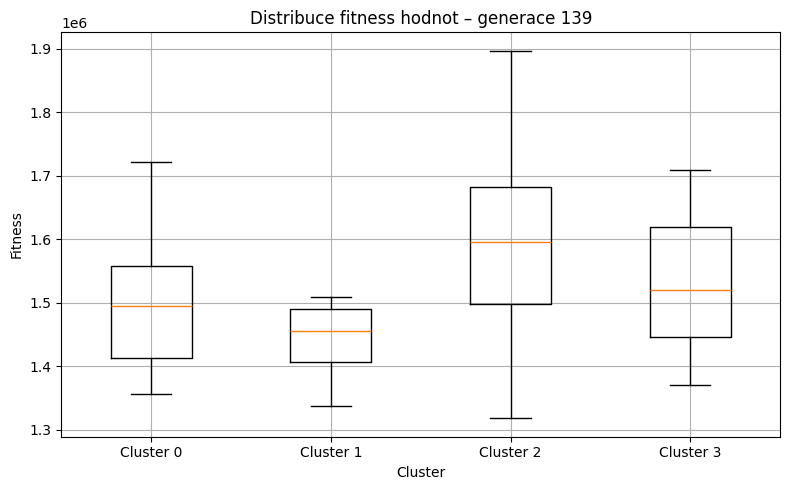

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 3 (3.0 %)
Změnili cluster jednou: 0 (0.0 %)
Změnili cluster vícekrát: 97 (97.0 %)


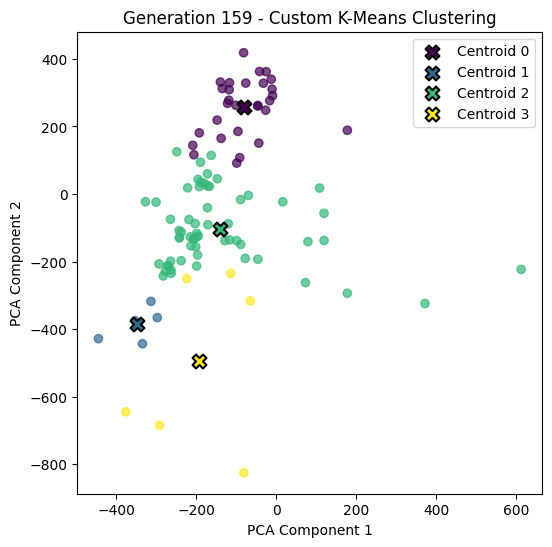

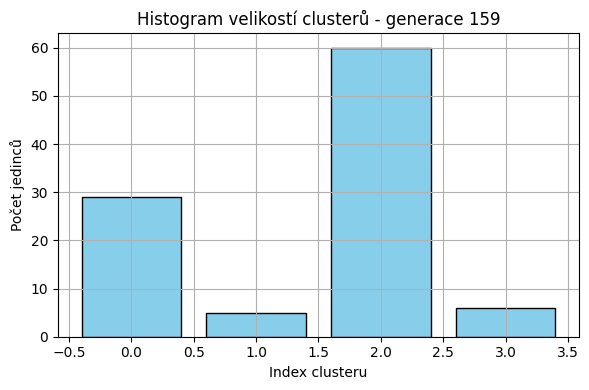


Stabilita mezi generací 0 → 19:
  Cluster 2 → 3: 7 jedinců (25.0 %)
  Cluster 2 → 2: 7 jedinců (25.0 %)
  Cluster 2 → 0: 5 jedinců (17.9 %)
  Cluster 2 → 1: 9 jedinců (32.1 %)
  Cluster 1 → 2: 9 jedinců (31.0 %)
  Cluster 1 → 0: 5 jedinců (17.2 %)
  Cluster 1 → 1: 10 jedinců (34.5 %)
  Cluster 1 → 3: 5 jedinců (17.2 %)
  Cluster 0 → 3: 7 jedinců (31.8 %)
  Cluster 0 → 1: 7 jedinců (31.8 %)
  Cluster 0 → 2: 4 jedinců (18.2 %)
  Cluster 0 → 0: 4 jedinců (18.2 %)
  Cluster 3 → 0: 7 jedinců (33.3 %)
  Cluster 3 → 2: 4 jedinců (19.0 %)
  Cluster 3 → 3: 6 jedinců (28.6 %)
  Cluster 3 → 1: 4 jedinců (19.0 %)

Stabilita mezi generací 19 → 39:
  Cluster 3 → 1: 4 jedinců (16.0 %)
  Cluster 3 → 2: 6 jedinců (24.0 %)
  Cluster 3 → 3: 12 jedinců (48.0 %)
  Cluster 3 → 0: 3 jedinců (12.0 %)
  Cluster 2 → 0: 7 jedinců (29.2 %)
  Cluster 2 → 2: 7 jedinců (29.2 %)
  Cluster 2 → 1: 4 jedinců (16.7 %)
  Cluster 2 → 3: 6 jedinců (25.0 %)
  Cluster 1 → 3: 13 jedinců (43.3 %)
  Cluster 1 → 2: 5 jedinců (16

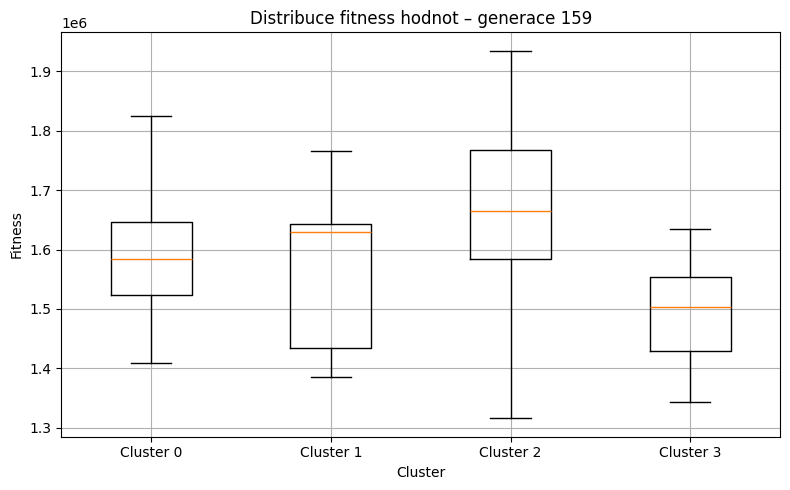

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 1 (1.0 %)
Změnili cluster jednou: 2 (2.0 %)
Změnili cluster vícekrát: 97 (97.0 %)


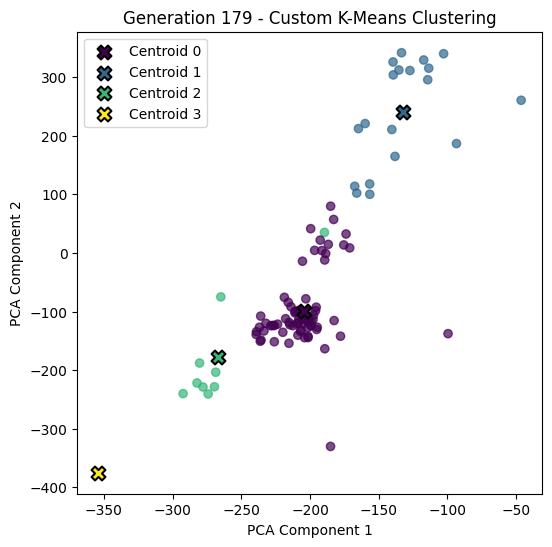

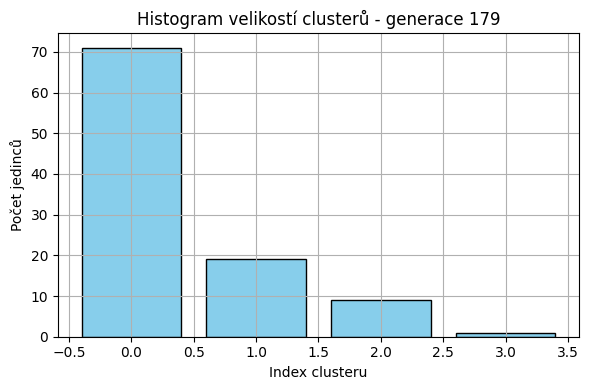


Stabilita mezi generací 0 → 19:
  Cluster 2 → 3: 7 jedinců (25.0 %)
  Cluster 2 → 2: 7 jedinců (25.0 %)
  Cluster 2 → 0: 5 jedinců (17.9 %)
  Cluster 2 → 1: 9 jedinců (32.1 %)
  Cluster 1 → 2: 9 jedinců (31.0 %)
  Cluster 1 → 0: 5 jedinců (17.2 %)
  Cluster 1 → 1: 10 jedinců (34.5 %)
  Cluster 1 → 3: 5 jedinců (17.2 %)
  Cluster 0 → 3: 7 jedinců (31.8 %)
  Cluster 0 → 1: 7 jedinců (31.8 %)
  Cluster 0 → 2: 4 jedinců (18.2 %)
  Cluster 0 → 0: 4 jedinců (18.2 %)
  Cluster 3 → 0: 7 jedinců (33.3 %)
  Cluster 3 → 2: 4 jedinců (19.0 %)
  Cluster 3 → 3: 6 jedinců (28.6 %)
  Cluster 3 → 1: 4 jedinců (19.0 %)

Stabilita mezi generací 19 → 39:
  Cluster 3 → 1: 4 jedinců (16.0 %)
  Cluster 3 → 2: 6 jedinců (24.0 %)
  Cluster 3 → 3: 12 jedinců (48.0 %)
  Cluster 3 → 0: 3 jedinců (12.0 %)
  Cluster 2 → 0: 7 jedinců (29.2 %)
  Cluster 2 → 2: 7 jedinců (29.2 %)
  Cluster 2 → 1: 4 jedinců (16.7 %)
  Cluster 2 → 3: 6 jedinců (25.0 %)
  Cluster 1 → 3: 13 jedinců (43.3 %)
  Cluster 1 → 2: 5 jedinců (16

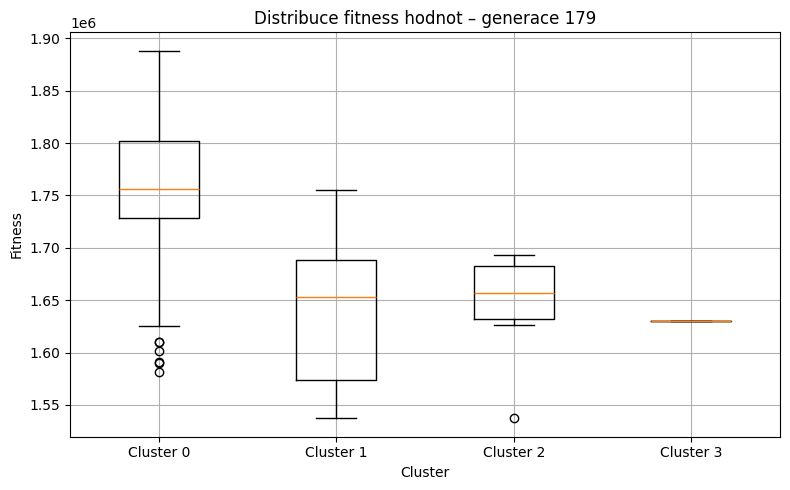

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 1 (1.0 %)
Změnili cluster jednou: 1 (1.0 %)
Změnili cluster vícekrát: 98 (98.0 %)


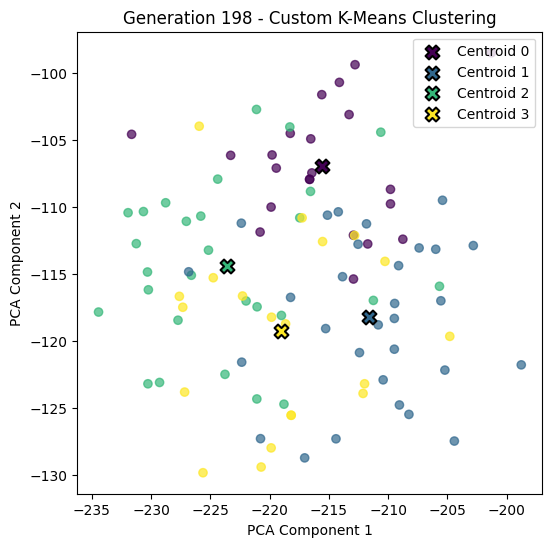

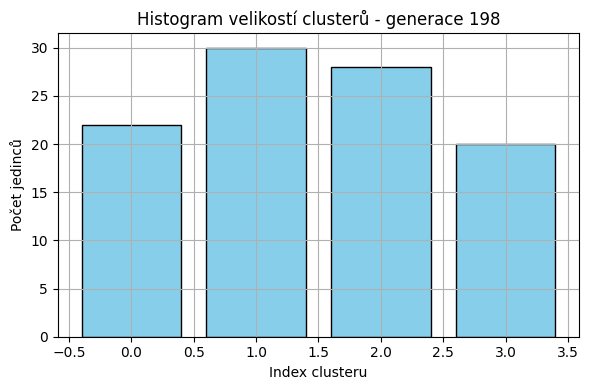


Stabilita mezi generací 0 → 19:
  Cluster 2 → 3: 7 jedinců (25.0 %)
  Cluster 2 → 2: 7 jedinců (25.0 %)
  Cluster 2 → 0: 5 jedinců (17.9 %)
  Cluster 2 → 1: 9 jedinců (32.1 %)
  Cluster 1 → 2: 9 jedinců (31.0 %)
  Cluster 1 → 0: 5 jedinců (17.2 %)
  Cluster 1 → 1: 10 jedinců (34.5 %)
  Cluster 1 → 3: 5 jedinců (17.2 %)
  Cluster 0 → 3: 7 jedinců (31.8 %)
  Cluster 0 → 1: 7 jedinců (31.8 %)
  Cluster 0 → 2: 4 jedinců (18.2 %)
  Cluster 0 → 0: 4 jedinců (18.2 %)
  Cluster 3 → 0: 7 jedinců (33.3 %)
  Cluster 3 → 2: 4 jedinců (19.0 %)
  Cluster 3 → 3: 6 jedinců (28.6 %)
  Cluster 3 → 1: 4 jedinců (19.0 %)

Stabilita mezi generací 19 → 39:
  Cluster 3 → 1: 4 jedinců (16.0 %)
  Cluster 3 → 2: 6 jedinců (24.0 %)
  Cluster 3 → 3: 12 jedinců (48.0 %)
  Cluster 3 → 0: 3 jedinců (12.0 %)
  Cluster 2 → 0: 7 jedinců (29.2 %)
  Cluster 2 → 2: 7 jedinců (29.2 %)
  Cluster 2 → 1: 4 jedinců (16.7 %)
  Cluster 2 → 3: 6 jedinců (25.0 %)
  Cluster 1 → 3: 13 jedinců (43.3 %)
  Cluster 1 → 2: 5 jedinců (16

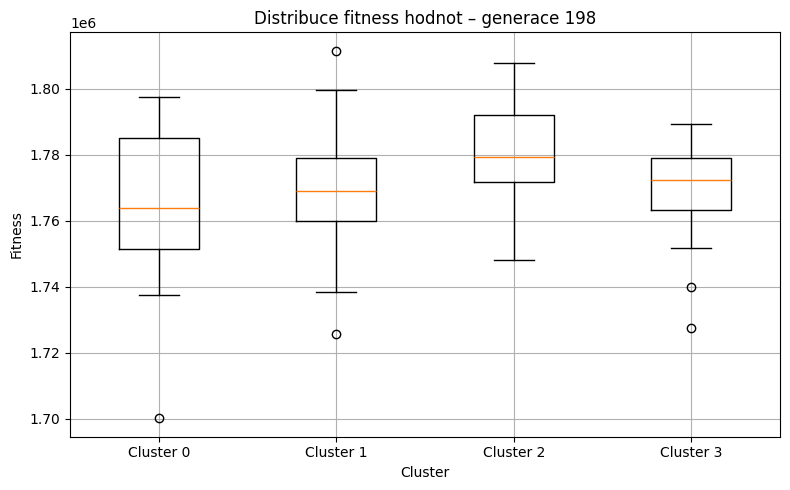

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 1 (1.0 %)
Změnili cluster jednou: 0 (0.0 %)
Změnili cluster vícekrát: 99 (99.0 %)


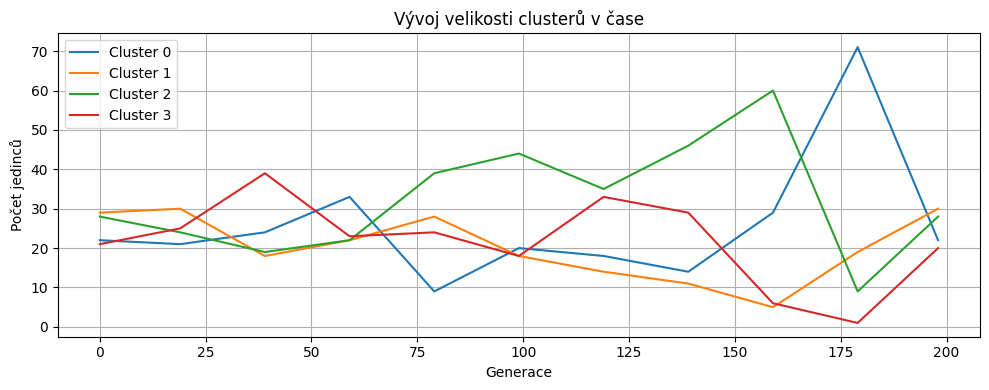

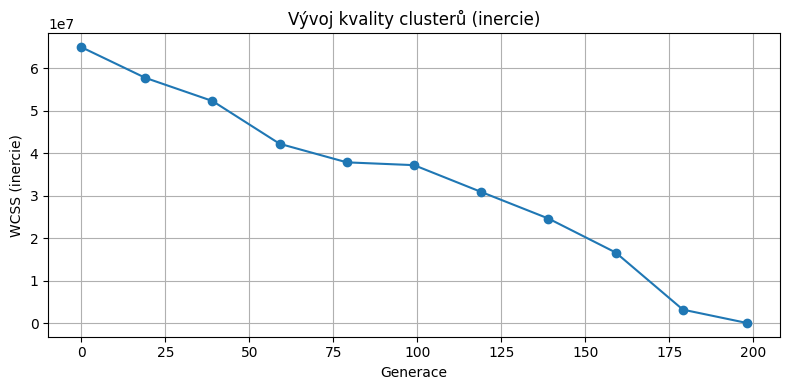

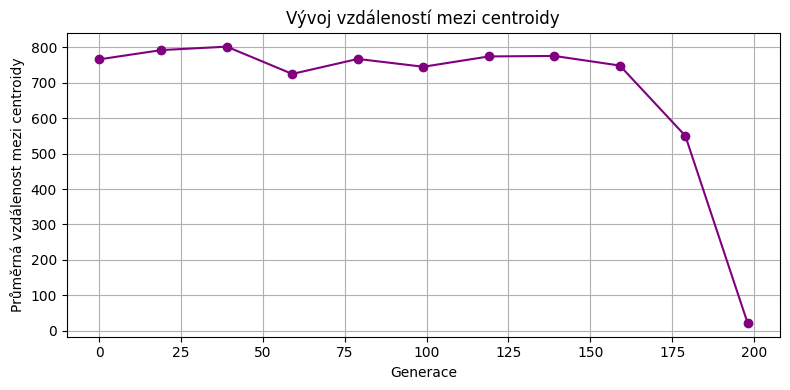


Posun centroidů mezi generací 0 a 19:
 - Cluster 0: 698.0610
 - Cluster 1: 822.5286
 - Cluster 2: 928.5762
 - Cluster 3: 1129.4887

Posun centroidů mezi generací 19 a 39:
 - Cluster 0: 575.6009
 - Cluster 1: 519.1558
 - Cluster 2: 685.3193
 - Cluster 3: 551.2284

Posun centroidů mezi generací 39 a 59:
 - Cluster 0: 592.2269
 - Cluster 1: 634.9725
 - Cluster 2: 776.6673
 - Cluster 3: 600.3961

Posun centroidů mezi generací 59 a 79:
 - Cluster 0: 684.6630
 - Cluster 1: 709.5213
 - Cluster 2: 489.9882
 - Cluster 3: 197.9963

Posun centroidů mezi generací 79 a 99:
 - Cluster 0: 967.5034
 - Cluster 1: 735.1437
 - Cluster 2: 282.8752
 - Cluster 3: 743.1519

Posun centroidů mezi generací 99 a 119:
 - Cluster 0: 498.4200
 - Cluster 1: 351.0141
 - Cluster 2: 250.9962
 - Cluster 3: 392.2744

Posun centroidů mezi generací 119 a 139:
 - Cluster 0: 191.9599
 - Cluster 1: 1009.7352
 - Cluster 2: 201.3252
 - Cluster 3: 373.8377

Posun centroidů mezi generací 139 a 159:
 - Cluster 0: 954.2716
 - Clus

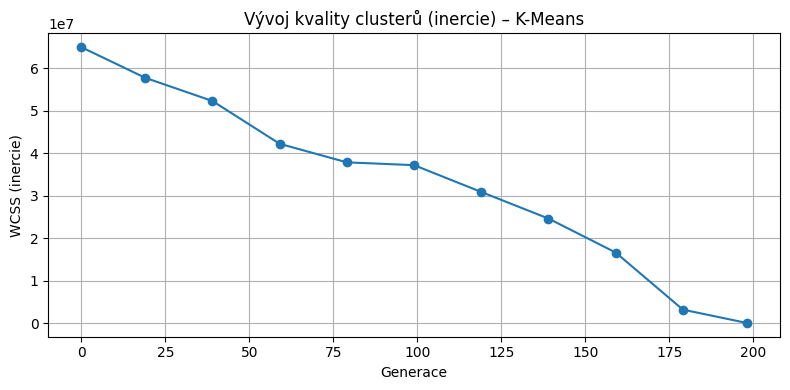

In [17]:
run("population_log_DE.csv", 4, 20)

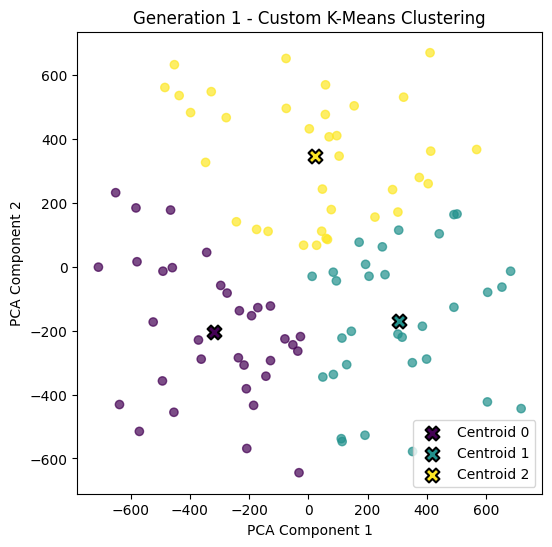

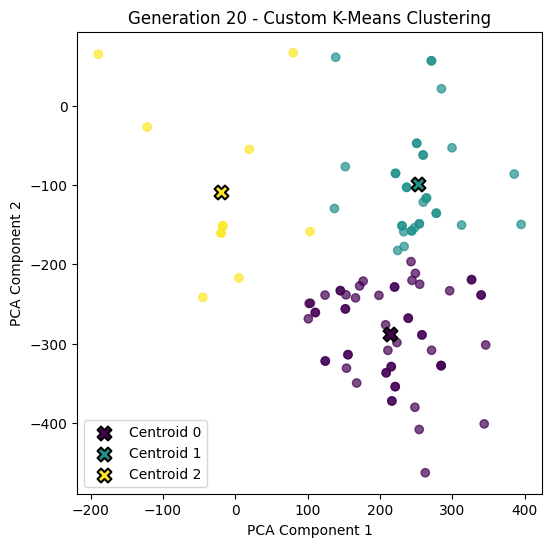

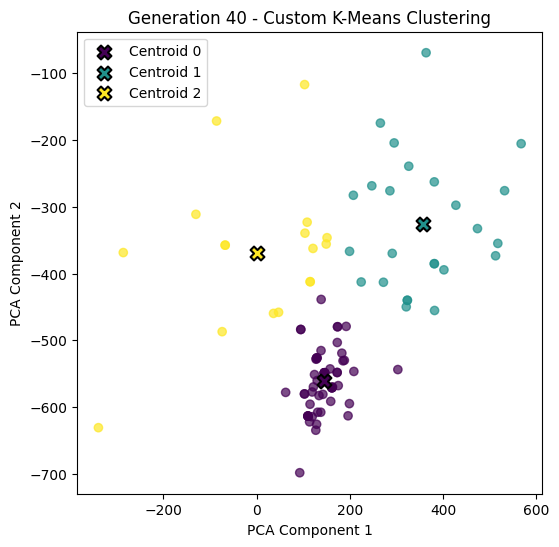

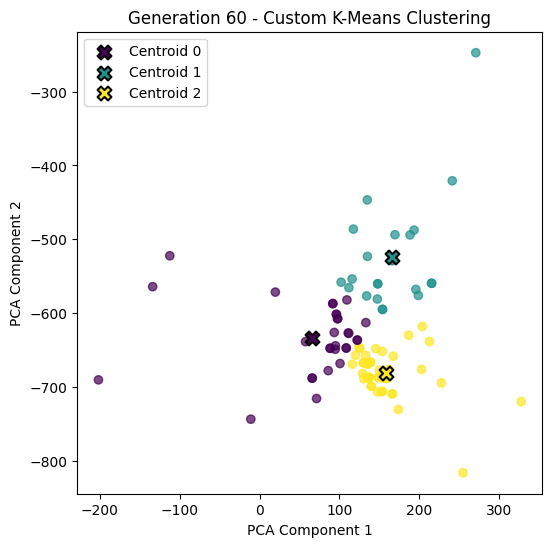

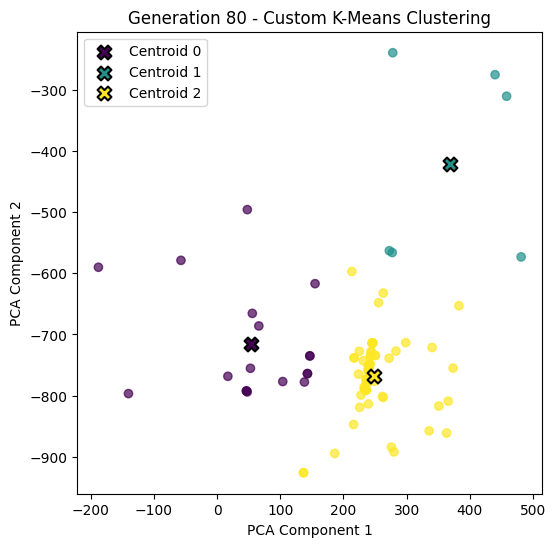

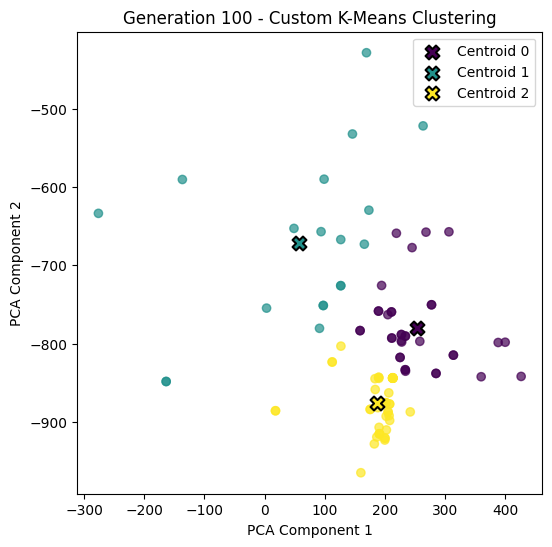

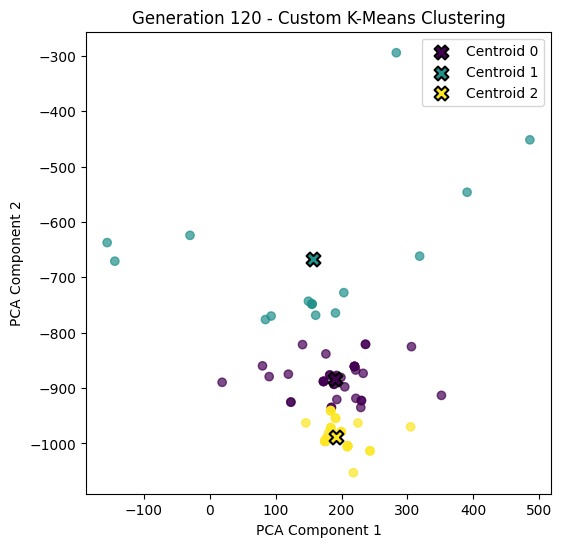

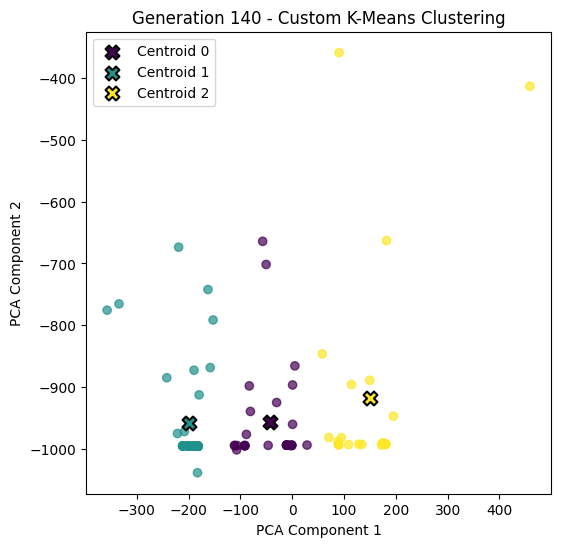

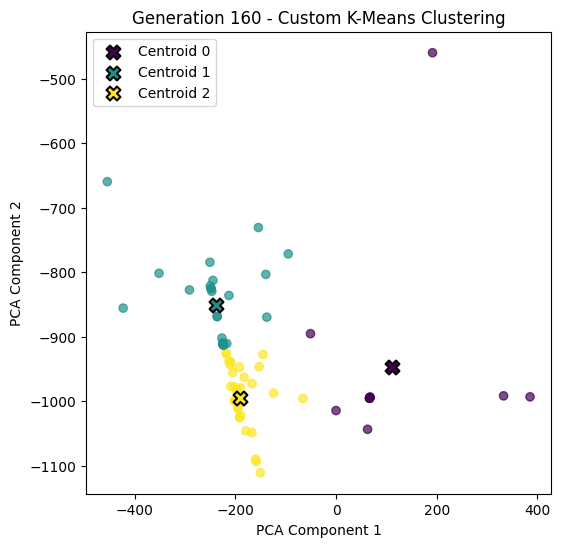

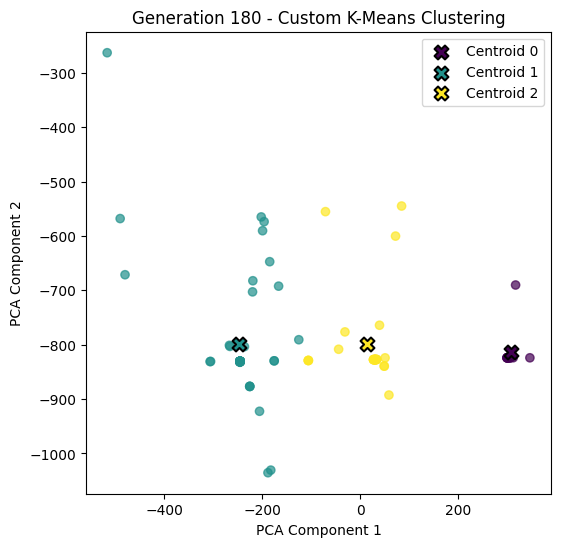

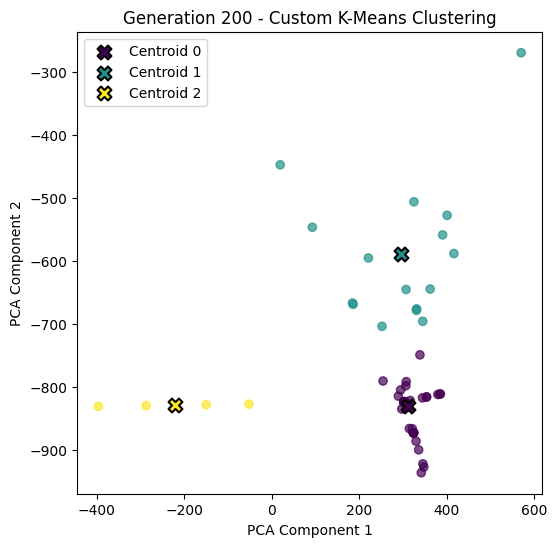

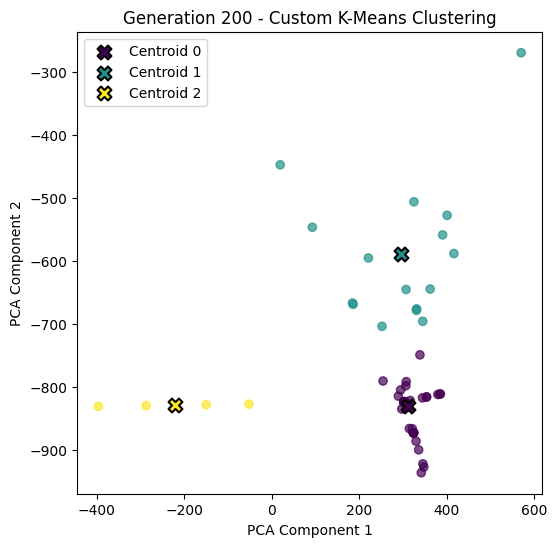

In [7]:
run("population_log_GA.csv", 3, 20)